# Deep Density Destructors

In [1]:
# Setup imports
from __future__ import division, print_function
import sys, os, warnings
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sys.path.append('..')  # Enable importing from package ddl without installing ddl

In [2]:
from ddl.linear import RandomOrthogonalEstimator
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
from ddl.tree import TreeDensity, TreeDestructor, RandomTreeEstimator
from sklearn.base import BaseEstimator, TransformerMixin
from ddl.deep import DeepDestructorCV, DeepDestructor

from ddl.independent import IndependentDensity, IndependentDestructor
from ddl.univariate import HistogramUnivariateDensity
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.base import clone
from ddl.univariate import HistogramUnivariateDensity, ScipyUnivariateDensity
from ddl.independent import IndependentInverseCdf
from ddl.linear import LinearProjector
from ddl.base import CompositeDestructor

## Data

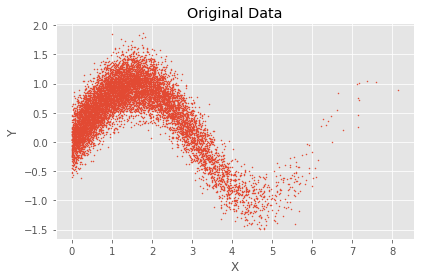

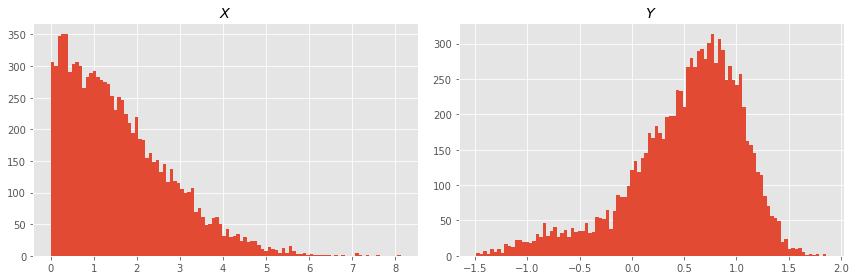

In [9]:
seed = 123
rng = np.random.RandomState(seed=seed)

num_samples = 10000
x = np.abs(2 * rng.randn(num_samples, 1))
y = np.sin(x) + 0.25 * rng.randn(num_samples, 1)
data = np.hstack((x, y))

# Scatter Data
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Original Data')
plt.tight_layout()

plt.show()

# Histograms
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].hist(data[:, 0], bins=100)
ax[0].set_title(r'$X$')
ax[1].hist(data[:, 1], bins=100)
ax[1].set_title(r'$Y$')
plt.tight_layout()
plt.show()

## Implementation I - Randomized Linear Destructor (ICML Experiment)

### Layers

In [8]:
# ==================================
# Layer 0 - init destructor
# ==================================

# Projects data onto the unit hypercube
l0_unit_hypercube = IndependentDestructor()



# ==================================
# Layer I - Gaussian Inverse CDF Function (marginally)
# ==================================

# Projects from unit hypercubee to a real-valued space
l1_mg_gauss = IndependentInverseCdf()

# ==================================
# Layer III - Linear Projector (PCA)
# ==================================

# Linearly project onto the principal components estimated via PCA
linear_estimator = PCA()

l2_rotation = LinearProjector(linear_estimator=linear_estimator)


# ==================================
# Layer IV - Independent Destructor
# ==================================

# Estimate independent Gaussian and project onto unit hypercube
l3_project = IndependentDestructor()

# ==================================
# Layer 1 - Independent Destructor
# ==================================

# Makes the marginals uniform via histogram estimator
univariate_estimator = HistogramUnivariateDensity(bounds=[0,1], bins=40, alpha=10)

independent_density = IndependentDensity(univariate_estimator)

l4_marginal_uniformization = IndependentDestructor(independent_density)


### Layer-By-Layer (Visualization)

#### Layer I

This apparently projects the data into the unit hypercube $\mathcal U[0,1]^d$. According to the documentation [here](https://destructive-deep-learning.readthedocs.io/en/latest/generated/ddl.independent.IndependentDestructor.html#ddl.independent.IndependentDestructor) this applies a univariate CDF to each feature **independently** of other features. We are allowed to specify which univariate densities for each feature. For example, we can use normal, uniform, etc. [Here](https://docs.scipy.org/doc/scipy/reference/stats.html) is a list of continuous distributions that we can use for this transformation. 

Default: Normal Distribution.

Algorithm:

1. Set Your Estimator (default=Normal)
2. Put a RV estimator per feature (marginal density fitting)
3. Fit the data to that rv distribution
    > Each rv in scipy.stats has a fit method which comes up with parameter estimates for the data.
    > E.g. The Norm will estimate the mean and variance and just use the Gaussian dist. But some other methods use the MLE to fit the data to the distribution.
4. Apply the CDF Function to that same dataset (marginally).

This full procedure is the default procedure

(1.5965316546871593, 1.1984944830447173)

In [70]:
import scipy.stats

norm1 = scipy.stats.norm
norm2 = scipy.stats.norm

norm1.fit(data[:, 0].reshape(-1, 1));
norm2.fit(data[:, 1].reshape(-1, 1));

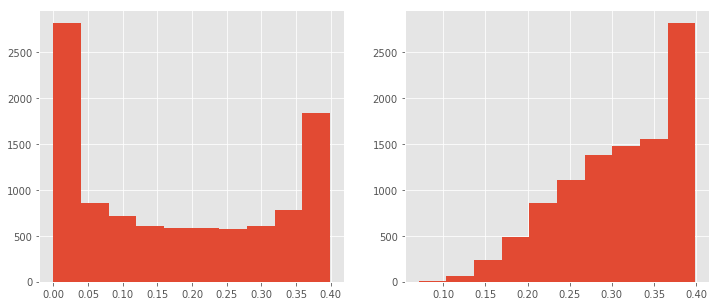

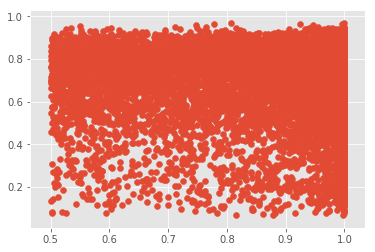

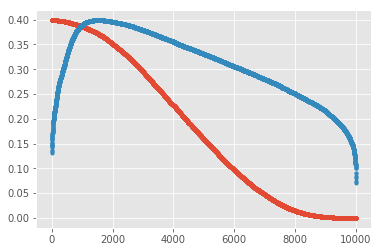

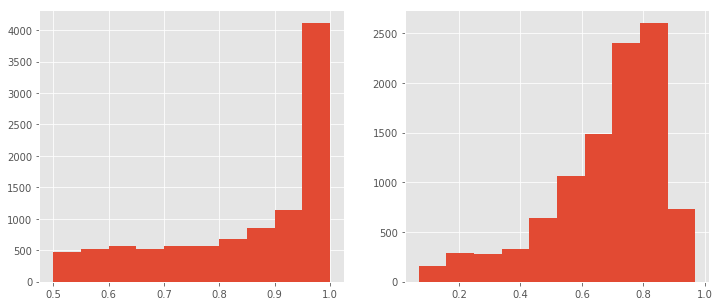

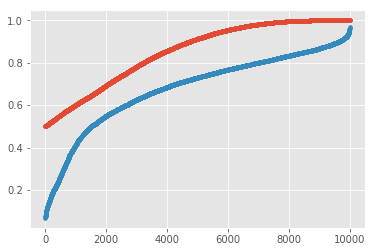

In [82]:
x1_pdf = norm1.pdf(np.sort(data[:, 0]))
x1_cdf = norm1.cdf(np.sort(data[:, 0]))

x2_pdf = norm2.pdf(np.sort(data[:, 1]))
x2_cdf = norm2.cdf(np.sort(data[:, 1]))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].hist(x1_pdf,)
ax[1].hist(x2_pdf,)

plt.show()

fig, ax = plt.subplots()

ax.scatter(
    norm1.cdf(data[:, 0]), 
    norm2.cdf(data[:, 1]))

plt.show()

fig, ax = plt.subplots()

ax.plot(x1_pdf, marker='.', linestyle='')
ax.plot(x2_pdf, marker='.', linestyle='')

plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].hist(x1_cdf,)
ax[1].hist(x2_cdf,)

plt.show()

fig, ax = plt.subplots()


ax.plot(x1_cdf, marker='.', linestyle='')
ax.plot(x2_cdf, marker='.', linestyle='')

plt.show()

In [30]:
uest1 = x1.univariate_densities_[0]

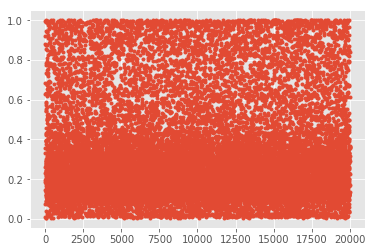

In [42]:
t = uest1.cdf(data)

fig, ax = plt.subplots()

ax.plot(t, marker='.', linestyle='')

plt.show()

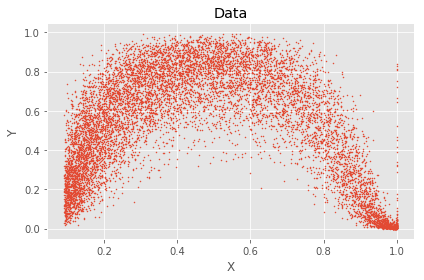

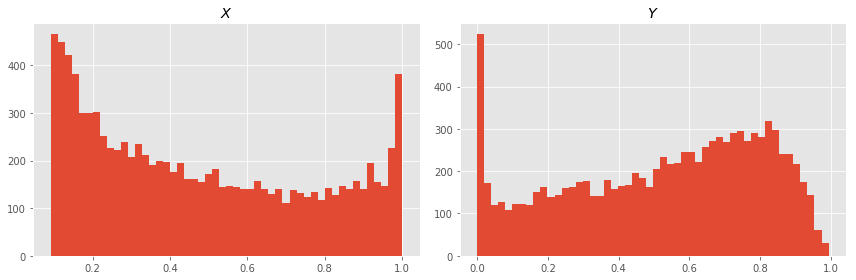

In [14]:
# ==================================
# Layer 0 - init destructor
# ==================================

# Projects data onto the unit hypercube
l0_unit_hypercube = IndependentDestructor()

x1 = l0_unit_hypercube.fit_transform(data)

# Data Together
plot_scatter(x1)

# Histograms
plot_histograms(x1)

## Implementation I - Deep Gaussian Copula Destructor

#### Layers

In [6]:
# ==================================
# Layer 0 - init destructor
# ==================================

# Projects data onto the unit hypercube
init_destructor = IndependentDestructor()

# ==================================
# Layer 1 - Independent Destructor
# ==================================

# Makes the marginals uniform via histogram estimator
univariate_estimator = HistogramUnivariateDensity(bounds=[0,1], bins=40, alpha=10)

independent_density = IndependentDensity(univariate_estimator)

l1_marginal_uniformization = IndependentDestructor(independent_density)

# ==================================
# Layer II - Gaussian Inverse CDF Function (marginally)
# ==================================

# Projects from unit hypercubee to a real-valued space
l2_mg_gauss = IndependentInverseCdf()

# ==================================
# Layer III - Linear Projector (PCA)
# ==================================

# Linearly project onto the principal components estimated via PCA
linear_estimator = PCA()

l3_rotation = LinearProjector(linear_estimator=linear_estimator)

# ==================================
# Layer IV - Independent Destructor
# ==================================

# Estimate independent Gaussian and project onto unit hypercube
l4_project = IndependentDestructor()


#### Layer-by-Layer - Visual